# Heat Waves Productivity Impact in Switzerland

In [2]:
import numpy as np
#import math
import pandas as pd
from pandas import DataFrame
%matplotlib inline
import matplotlib.pyplot as plt
import pickle
from scipy.sparse import csr_matrix, vstack
from climada.engine import Impact
import sys 
sys.path.append('../../src/util')
sys.path.append('../../src/write_entities')
fig_dir = '../figures/'
import palettable
from stacked_grouped_barplot import plot_clustered_stacked
from stacked_grouped_barplot_error \
import plot_clustered_stacked_with_error
from define_exposures import call_exposures
from shapefile_masks import vector_shapefile_mask



## Base Switzerland


First import the pickle containing a dictionnary of the calculated damage costs. The dictionnary is a nested dictionnary, 
with the first layer being the different scenarios, the second the years. For each scenario and each year, there is a panda dataframe with the 4 types of exposures as columns, according to the physical expenditures of the labor performed.
The rows correspond to the output of each monte carlo.


In [3]:
pickle_in = \
open('../../output/impact_ch/damage_cost_all_branches_1000mc_all_uncertainties_CH.pickle','rb')
damage_CH= pickle.load(pickle_in)    

add the total damage

In [4]:
# Add a column to each dataframe with the sum of all expenditure for each monte carlo.
for s_ in damage_CH:
    for y_ in damage_CH[s_]:
        damage_CH[s_][y_]['total'] \
        = damage_CH[s_][y_][list(damage_CH[s_][y_].columns)].sum(axis=1)       

### Distribution of damage costs for each scenario
make dictionnary with the scenarios as keys. For each scenario, make a new a daframe with the years as columns
and the total cost for the different simulations in the rows. We can then make a plot of the distribution for each scenario and see how the distribution moves with the years


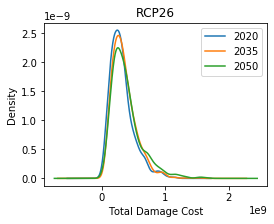

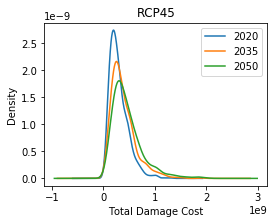

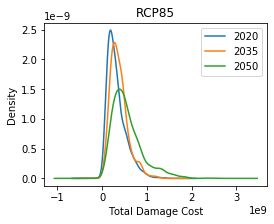

In [5]:

dataframes = {}
for s_ in damage_CH:

    fig, ax = plt.subplots(figsize=(4, 3))
    dataframes[s_] = pd.DataFrame()

    for y_ in damage_CH[s_]:
        dataframes[s_][y_] = damage_CH[s_][y_]['total']
        dataframes[s_][y_].plot.kde(label=y_)
        title = s_
        ax.legend()
        ax.set_title(title)
        ax.set_xlabel('Total Damage Cost')


    #fig_name = ''.join([fig_dir,'costs_distribution','_',s_,'_' , canton ,branches,'.pdf'])
    #plt.savefig(fig_name,bbox_inches='tight')        



### Damage cost for each scenario, year and labor type

The damage for 2065 was calculated after but I wanted to add it to the plot so imported it her

In [18]:
pickle_in = \
open('../../output/impact_ch/damage_cost_all_branches_100mc_all_uncertainties_CH_2065.pickle','rb')
damage_CH_2065= pickle.load(pickle_in)  
for s_ in damage_CH_2065:
    damage_CH_2065[s_]['2065']['total']\
    = damage_CH_2065[s_]['2065'][list(damage_CH_2065[s_]['2065'].columns)].sum(axis=1)       

make the plots
again, we make a new dictionnary of the scenarios, this time with the different types of exposures
as columns and the years in the rows. Then, the clustered stacked barplots can be called, 
with the dictionnary of panda dataframes as input, where the rows of each dataframe correspond to the grouping 
criteria (by year), the columns to the stacks (the labor types) and the dictionnary keys to the hatches (the scenario).  

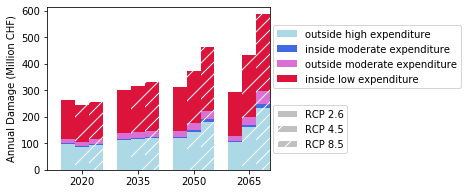

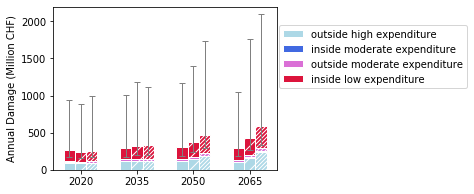

In [23]:
#again, we make a new dictionnary of the scenarios, this time with the different types of exposures
#as columns and the years in the rows. Then, the clustered stacked barplots can be called, 
#with the dictinnary of panda dataframes as input, where the rows of each dataframe correspond to the grouping 
#criteria (by year), the columns to the stacks (the labor types) 
#and the dictionnary keys to the hatches (the scenario).  
RCPs = {'RCP26':'RCP 2.6', 'RCP45':'RCP 4.5', 'RCP85':'RCP 8.5'}
dataframes = {}
minimums = {}
maximums = {}
for s_ in damage_CH:
    dataframes[RCPs[s_]] = pd.DataFrame()
    maximums[RCPs[s_]] = pd.DataFrame()
    minimums[RCPs[s_]] = pd.DataFrame()
    
    for y_ in damage_CH[s_]:
        dataframes[RCPs[s_]][y_] = ((damage_CH[s_][y_].iloc[:,0:-1]).median())/1000000
        maximums[RCPs[s_]][y_] = ((damage_CH[s_][y_].iloc[:,:]).quantile(0.95))/1000000
        minimums[RCPs[s_]][y_] = ((damage_CH[s_][y_].iloc[:,:]).quantile(0.05))/1000000
    
    dataframes[RCPs[s_]]['2065'] = ((damage_CH_2065[s_]['2065'].iloc[:,0:-1]).median())/1000000
    maximums[RCPs[s_]]['2065'] = ((damage_CH_2065[s_]['2065'].iloc[:,:]).quantile(0.95))/1000000
    minimums[RCPs[s_]]['2065'] = ((damage_CH_2065[s_]['2065'].iloc[:,:]).quantile(0.05))/1000000
    
    
    dataframes[RCPs[s_]] = dataframes[RCPs[s_]].transpose()
    maximums[RCPs[s_]] = maximums[RCPs[s_]].transpose()
    minimums[RCPs[s_]] = minimums[RCPs[s_]].transpose()


fig, ax = plt.subplots(figsize=(4,3))
plot_clustered_stacked(dataframes,title = '',color= ['lightblue','royalblue','orchid','crimson'])
plt.ylabel('Annual Damage (Million CHF)')
ax.ticklabel_format(style='plain')

plt.savefig(''.join([fig_dir,'ch','_predicted_damage_4_3.pdf']),bbox_inches='tight')

fig, ax = plt.subplots(figsize=(4,3))
plot_clustered_stacked_with_error(dataframes,minimums,maximums,color= ['lightblue','royalblue','orchid','crimson'])
plt.ylabel('Annual Damage (Million CHF)')
plt.savefig(''.join([fig_dir,'ch','_predicted_damage_error_4_3.pdf']),bbox_inches='tight')




## Sensibility Analysis
performed for the canton of bern


open the output corresponding to the sensibility. This time, the file is a three layers nested dictionnary
with the variable being varied (the others are fixes) as the outer level, the scenario as the center and 
the year as the inner level.
Then, calculate the total cost.


In [62]:
pickle_in =\
open('../../output/impact_sensitivity/damage_cost_all_branches_1000mc_all_uncertainties_independently_Bern.pickle','rb')
sensitivity = pickle.load(pickle_in)
 
for v_ in sensitivity:
    for s_ in sensitivity[v_]:

        for y_ in sensitivity[v_][s_]:

            sensitivity[v_][s_][y_]['total'] = sensitivity[v_][s_][y_][list(sensitivity[v_][s_][y_].columns)].sum(axis=1)



plot the distribution of the difference to the monte carlo median costs when each variable is varied independently.
for the scenarios RCP26 and RCP85 in the year 2050

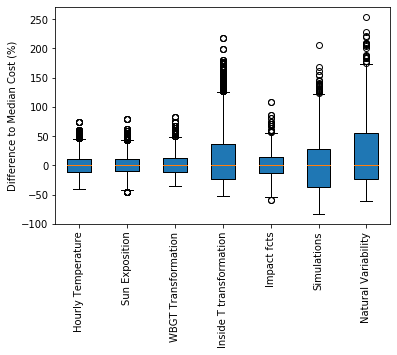

In [79]:
#plot the distribution of the difference to the monte carlo median costs when each variable is varied independently.
#for the scenarios RCP26 and RCP85 in the year 2050
scenarios = ['RCP85']
y = '2050'
sensitivity_variables = ['Hourly Temperature', 'Sun Exposition', 'WBGT Transformation', 'Inside T transformation','Impact fcts','Simulations','Natural Variability']

for s_ in scenarios:    
    fig, ax = plt.subplots()
    diff_median = []
    for v_ in sensitivity:
        diff_median.append((sensitivity[v_][s_][y_]['total']-np.median(sensitivity[v_][s_][y_]['total']))/np.median(sensitivity[v_][s_][y_]['total'])*100)
        if v_ != 'simulations':
            ax.boxplot(diff_median, patch_artist=True)

    
    #ax.boxplot(diff_median, patch_artist=True)
    ax.set_xticks([1,2,3,4,5,6,7])
    ax.set_ylabel('Difference to Median Cost (%)')

    ax.set_xticklabels(sensitivity_variables,rotation=90)
    plt.savefig(''.join([fig_dir,s_,'sensibility_bern_all.pdf']),bbox_inches='tight')


do the same but considering all uncertainties belonging to the impact model together and the one coming from
the ch2018 data separatly

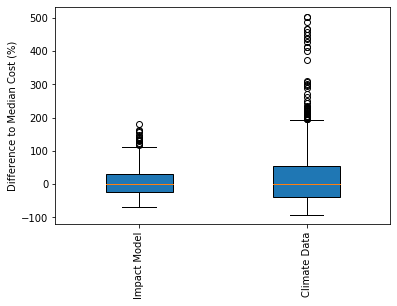

In [24]:
pickle_in = open('../../output/impact_sensitivity/damage_cost_all_branches_1000mc_natural_variability_uncertainty_Bern.pickle','rb')
ch2018_sensitivity = pickle.load(pickle_in)

pickle_in = open('../../output/impact_sensitivity/damage_cost_all_branches_1000mc_model_uncertainty_Bern.pickle','rb')
model_sensitivity = pickle.load(pickle_in)

s = 'RCP85'
y = '2050'

sensitivity_variables = ['Impact Model','Climate Data']
fig, ax = plt.subplots()
diff_median = []

model_sensitivity['model'][s][y]['total'] = model_sensitivity['model'][s][y][list(model_sensitivity['model'][s][y].columns)].sum(axis=1)
diff_median.append((model_sensitivity['model'][s][y]['total']-np.median(model_sensitivity['model'][s][y]['total']))/np.median(model_sensitivity['model'][s][y]['total'])*100)

ch2018_sensitivity['ch2018'][s][y]['total'] = ch2018_sensitivity['ch2018'][s][y][list(ch2018_sensitivity['ch2018'][s][y].columns)].sum(axis=1)
diff_median.append((ch2018_sensitivity['ch2018'][s][y]['total']-np.median(ch2018_sensitivity['ch2018'][s][y]['total']))/np.median(ch2018_sensitivity['ch2018'][s][y]['total'])*100)


ax.boxplot(diff_median, patch_artist=True,widths=0.4)


#ax.boxplot(diff_median, patch_artist=True)
ax.set_xticks([1,2])
ax.set_ylabel('Difference to Median Cost (%)')

ax.set_xticklabels(sensitivity_variables,rotation=90)
plt.savefig(''.join([fig_dir,'',s_,'_sensibility_bern_model_data.pdf']),bbox_inches='tight')


### Plotting the Spatial Impact 

In [169]:
#we now open the matrice output which is again a three level nested dictionnary with a csr matrix at the end
#There is one matrix for each combination of scenario, year and exposure type.
#Each matrix corresponds to the median of all the monte carlos for each exposure.

pickle_in = open('../../output/impact_ch/median_cost_matrix_all_branches_1000mc_all_uncertainties_CH.pickle','rb')
MATRICES = pickle.load(pickle_in)
    

we call the exposures to be able to calculate the percentage damaged


In [170]:
#we call the exposures to be able to calculate the percentage damaged
directory_exposures          = '../../input_data/exposures/'
EXPOSURES, exposures_name    = call_exposures()

for e_ in exposures_name: # get the yearly value of the exposures, as the exposures from call_exposures() are hourly
    EXPOSURES[e_].value = EXPOSURES[e_].value*40*52


2020-02-03 11:42:18,822 - climada.util.coordinates - INFO - Setting geometry points.
2020-02-03 11:42:26,188 - climada.entity.exposures.base - INFO - tag metadata set to default value:  File: 
 Description: 
2020-02-03 11:42:26,189 - climada.entity.exposures.base - INFO - ref_year metadata set to default value: 2018
2020-02-03 11:42:26,189 - climada.entity.exposures.base - INFO - meta metadata set to default value: None
2020-02-03 11:42:26,190 - climada.entity.exposures.base - INFO - centr_ not set.
2020-02-03 11:42:26,190 - climada.entity.exposures.base - INFO - deductible not set.
2020-02-03 11:42:26,191 - climada.entity.exposures.base - INFO - cover not set.
2020-02-03 11:42:26,191 - climada.entity.exposures.base - INFO - category_id not set.
2020-02-03 11:42:26,192 - climada.entity.exposures.base - INFO - region_id not set.
2020-02-03 11:42:33,140 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.
2020-02-03 11:42:37,669 - climada.util.coordinates -

calculate percentage of exposures affected

In [212]:
total_exposure = sum(EXPOSURES[e_].value.sum() for e_ in EXPOSURES) 
print((damage_CH['RCP85']['2050']['total'].median()/total_exposure)*100)

0.1293315015249697


calculate percentage of inside low physical activity exposures affected

In [12]:
print((damage_CH['RCP85']['2050']['inside low expenditure'].median()\
       /EXPOSURES['inside low expenditure'].value.sum())*100)

0.09698558523821534


calculate percentage of outside high physical activity exposures affected

In [210]:
print((damage_CH['RCP85']['2050']['outside high expenditure'].quantile(0.95)/EXPOSURES['outside high expenditure'].value.sum())*100)

1.3159580297408129


rewrite the impact from the impact matrix of the low and high expenditure exposures:

In [178]:
median_impact_2050_RCP85_inside_low = Impact()
median_impact_2050_RCP85_inside_low.coord_exp =\
np.stack([EXPOSURES['inside low expenditure'].latitude.values,EXPOSURES['inside low expenditure'].longitude.values], axis=1)
median_impact_2050_RCP85_inside_low.event_id = 1
median_impact_2050_RCP85_inside_low.imp_mat =csr_matrix(MATRICES['RCP85']['2050']['inside low expenditure']) 
median_impact_2050_RCP85_inside_low.unit = 'CHF'

median_impact_2050_RCP85_outside_high = Impact()
median_impact_2050_RCP85_outside_high.coord_exp =\
np.stack([EXPOSURES['outside high expenditure'].latitude.values,EXPOSURES['outside high expenditure'].longitude.values], axis=1)
median_impact_2050_RCP85_outside_high.event_id = 1
median_impact_2050_RCP85_outside_high.imp_mat =\
csr_matrix(MATRICES['RCP85']['2050']['outside high expenditure']) 
median_impact_2050_RCP85_outside_high.unit = 'CHF'

plot the maps for low physical activity exposure in percentage and absolute number. 
Plot the map for the high physical activity exposure in percentage

/Users/zeliestalhanske/anaconda3/climada_python-1.3.1/climada/util/plot.py:318: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()
/Users/zeliestalhanske/anaconda3/climada_python-1.3.1/climada/util/plot.py:318: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()
/Users/zeliestalhanske/anaconda3/climada_python-1.3.1/climada/util/plot.py:318: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()
/Users/zeliestalhanske/anaconda3/climada_python-1.3.1/climada/util/plot.py:318: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


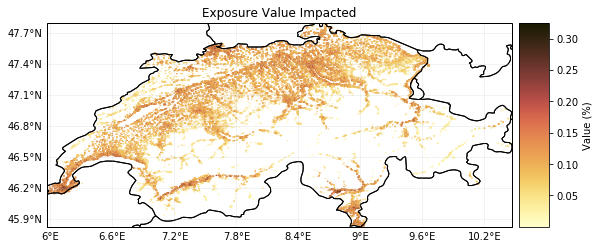

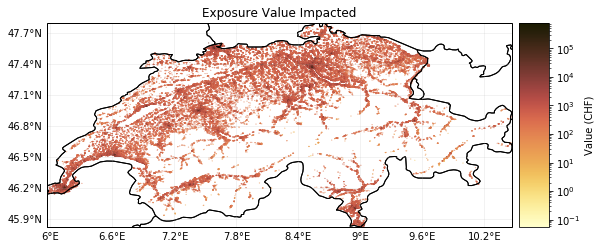

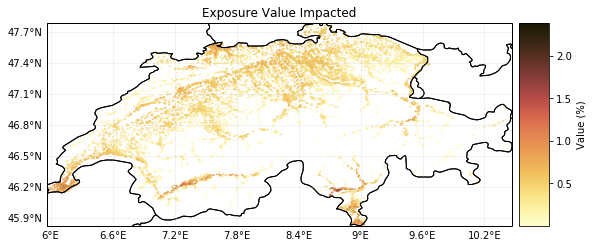

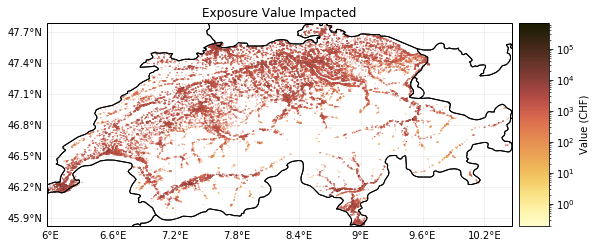

In [179]:
cm= palettable.scientific.sequential.LaJolla_20.mpl_colormap

#plot the impact as a percentage of the total exposures value for the low and high expenditure exposures 
median_impact_2050_RCP85_inside_low.plot_hexbin_impact_exposure(event_id=[0],percentage=True,exposures=EXPOSURES['inside low expenditure'],pop_name = False,cmap=cm)
plt.savefig(''.join([fig_dir,'ch','_map_low_percentage.pdf']),bbox_inches='tight')


median_impact_2050_RCP85_inside_low.plot_hexbin_impact_exposure(event_id=[0],pop_name = False,cmap=cm,bins='log')
plt.savefig(''.join([fig_dir,'ch','_map_high_total_damage.pdf.pdf']),bbox_inches='tight')


median_impact_2050_RCP85_outside_high.plot_hexbin_impact_exposure(event_id=[0],percentage=True,exposures=EXPOSURES['outside high expenditure'],pop_name = False,cmap=cm)
plt.savefig(''.join([fig_dir,'ch','_map_high_percentage.pdf']),bbox_inches='tight')


#plot the impact of the total exposures value for the low and high expenditure exposures 

median_impact_2050_RCP85_outside_high.plot_hexbin_impact_exposure(event_id=[0],pop_name = False,cmap=cm,bins='log')


### Kantons 

The damage for the different kantons can be computed directly from the model, so that we also get the distribution of the probabilistic damage. If we only want the median damage, it can also be optained from the swiss level impact matrix, requiring no further simulations. 

First let's redo the damage plot for Zurich only

In [315]:
pickle_in = open('../../output/impact_cantons/damage_cost_all_branches_1020mc_all_uncertainties_Zürich.pickle','rb')
zurich = pickle.load(pickle_in)


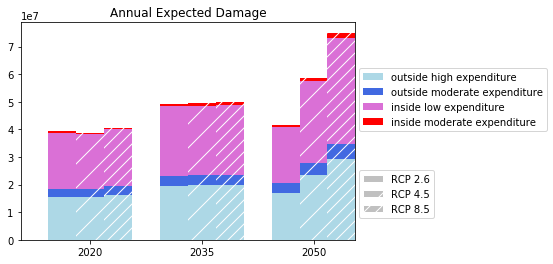

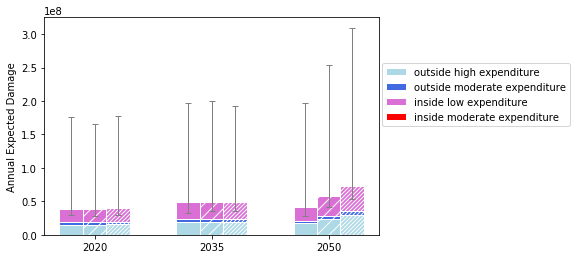

In [316]:
RCP = {'RCP26':'RCP 2.6', 'RCP45':'RCP 4.5', 'RCP85':'RCP 8.5'}


for s_ in zurich:
    for y_ in zurich[s_]:
        zurich[s_][y_]['total'] = zurich[s_][y_][list(zurich[s_][y_].columns)].sum(axis=1)
        
        

dataframe = {}
minimums = {}
maximums = {}
for s_ in zurich:
    dataframe[RCP[s_]] = pd.DataFrame()
    maximums[RCP[s_]] = pd.DataFrame()
    minimums[RCP[s_]] = pd.DataFrame()
    for y_ in zurich[s_]:
        dataframe[RCP[s_]][y_] = ((zurich[s_][y_].iloc[:,0:-1]).median())
        maximums[RCP[s_]][y_] = (zurich[s_][y_].iloc[:,:].quantile(0.95))
        minimums[RCP[s_]][y_] = (zurich[s_][y_].iloc[:,:].quantile(0.05))
    dataframe[RCP[s_]] = dataframe[RCP[s_]].transpose()
    maximums[RCP[s_]] = maximums[RCP[s_]].transpose()
    minimums[RCP[s_]] = minimums[RCP[s_]].transpose()

fig, ax = plt.subplots()

plot_clustered_stacked(dataframe,title = 'Annual Expected Damage',\
                       color= ['lightblue','royalblue','orchid','red'])
#plt.savefig(''.join(['fig_dir',canton,'_',branches,'_predicted_damage.pdf']),bbox_inches='tight')


fig, ax = plt.subplots()

plot_clustered_stacked_with_error(dataframe,minimums,maximums,color= ['lightblue','royalblue','orchid','red'])

plt.savefig(''.join(['fig_dir',canton,'_',branches,'_predicted_damage_error_zurich.pdf']),bbox_inches='tight')


get the exposures for the different cantons. takes a lot of time (30 minutes for 5 cantons)

In [195]:


shp_dir = '../../input_data/shapefiles/KANTONS_projected_epsg4326/swissBOUNDARIES3D_1_3_TLM_KANTONSGEBIET_epsg4326.shp'

#dictionnaries in which to save the impact for the low/high expenditure of the given cantons for 2050.
IMPACT_low_2050 = {} 
IMPACT_high_2050 = {} 
cantons = ['Zürich','Genève','Luzern','Valais','Ticino']

cantons_2050_fraction_low = pd.DataFrame(columns = list(MATRICES.keys()), index = cantons)
cantons_2050_fraction_high = pd.DataFrame(columns = list(MATRICES.keys()), index = cantons)

EXPOSURES_cantons = {}

for c_ in cantons:
    EXPOSURES_cantons[c_],exposures_name = call_exposures(kanton = c_)





2020-02-03 22:13:56,474 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.
2020-02-03 22:13:57,046 - climada.entity.exposures.base - INFO - crs set to default value: {'init': 'epsg:4326', 'no_defs': True}
2020-02-03 22:13:57,047 - climada.entity.exposures.base - INFO - tag metadata set to default value:  File: 
 Description: 
2020-02-03 22:13:57,048 - climada.entity.exposures.base - INFO - ref_year metadata set to default value: 2018
2020-02-03 22:13:57,048 - climada.entity.exposures.base - INFO - meta metadata set to default value: None
2020-02-03 22:13:57,049 - climada.entity.exposures.base - INFO - centr_ not set.
2020-02-03 22:13:57,049 - climada.entity.exposures.base - INFO - deductible not set.
2020-02-03 22:13:57,050 - climada.entity.exposures.base - INFO - cover not set.
2020-02-03 22:13:57,051 - climada.entity.exposures.base - INFO - category_id not set.
2020-02-03 22:13:57,051 - climada.entity.exposures.base - INFO - region_id not set.
2020-02

2020-02-03 22:23:01,104 - climada.entity.exposures.base - INFO - ref_year metadata set to default value: 2018
2020-02-03 22:23:01,104 - climada.entity.exposures.base - INFO - meta metadata set to default value: None
2020-02-03 22:23:01,105 - climada.entity.exposures.base - INFO - centr_ not set.
2020-02-03 22:23:01,106 - climada.entity.exposures.base - INFO - deductible not set.
2020-02-03 22:23:01,107 - climada.entity.exposures.base - INFO - cover not set.
2020-02-03 22:23:01,107 - climada.entity.exposures.base - INFO - category_id not set.
2020-02-03 22:23:01,108 - climada.entity.exposures.base - INFO - region_id not set.
2020-02-03 22:24:06,306 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.
2020-02-03 22:24:06,572 - climada.entity.exposures.base - INFO - crs set to default value: {'init': 'epsg:4326', 'no_defs': True}
2020-02-03 22:24:06,573 - climada.entity.exposures.base - INFO - tag metadata set to default value:  File: 
 Description: 
2020-02

2020-02-03 22:32:18,099 - climada.entity.exposures.base - INFO - deductible not set.
2020-02-03 22:32:18,100 - climada.entity.exposures.base - INFO - cover not set.
2020-02-03 22:32:18,100 - climada.entity.exposures.base - INFO - category_id not set.
2020-02-03 22:32:18,101 - climada.entity.exposures.base - INFO - region_id not set.
2020-02-03 22:33:22,772 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.
2020-02-03 22:33:22,972 - climada.entity.exposures.base - INFO - crs set to default value: {'init': 'epsg:4326', 'no_defs': True}
2020-02-03 22:33:22,973 - climada.entity.exposures.base - INFO - tag metadata set to default value:  File: 
 Description: 
2020-02-03 22:33:22,974 - climada.entity.exposures.base - INFO - ref_year metadata set to default value: 2018
2020-02-03 22:33:22,974 - climada.entity.exposures.base - INFO - meta metadata set to default value: None
2020-02-03 22:33:22,975 - climada.entity.exposures.base - INFO - centr_ not set.
2020-02

rebuilt the impacts for the different cantons from the impact matrix.
next, we sum all the impacts in a year for the cantons and we devide those by the total yearly value of the exposures

In [213]:

for s_ in MATRICES: # the Impacts are reconstructed and transformed to exposures, as we already have a function in the impact class to mask the values outside the cantons
    IMPACT_low_2050[s_] = Impact()
    IMPACT_low_2050[s_].coord_exp = np.stack([EXPOSURES['inside low expenditure'].latitude.values,EXPOSURES['inside low expenditure'].longitude.values], axis=1)
    IMPACT_low_2050[s_].event_id = 1
    IMPACT_low_2050[s_].imp_mat =csr_matrix(MATRICES[s_]['2050']['inside low expenditure']) 
    IMPACT_low_2050[s_] = IMPACT_low_2050[s_]._build_exp_events([0], percentage = False, exposures=None)

    IMPACT_high_2050[s_] = Impact()
    IMPACT_high_2050[s_].coord_exp = np.stack([EXPOSURES['outside high expenditure'].latitude.values,EXPOSURES['outside high expenditure'].longitude.values], axis=1)
    IMPACT_high_2050[s_].event_id = 1
    IMPACT_high_2050[s_].imp_mat =csr_matrix(MATRICES[s_]['2050']['outside high expenditure']) 
    IMPACT_high_2050[s_] = IMPACT_high_2050[s_]._build_exp_events([0], percentage = False, exposures=None)

    for c_ in cantons: #apply the mask for the given canton and devide by the yearly value of the exposure
        cantons_2050_fraction_low[s_][c_] = vector_shapefile_mask(IMPACT_low_2050[s_],shp_dir,c_,4326,4326).value.sum()\
        /(EXPOSURES_cantons[c_]['inside low expenditure'].value.sum()*8*5*52)*100
        cantons_2050_fraction_high[s_][c_] = vector_shapefile_mask(IMPACT_high_2050[s_],shp_dir,c_,4326,4326).value.sum()\
        /(EXPOSURES_cantons[c_]['outside high expenditure'].value.sum()*8*5*52)*100


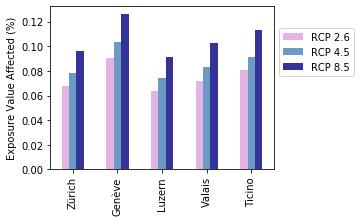

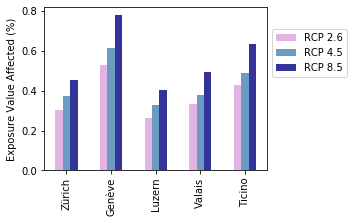

In [325]:
#barplot for 2050 showing the percentage of exposures affected for the different scenarios in the different cantons
cantons_2050_fraction_low.columns = ['RCP 2.6', 'RCP 4.5', 'RCP 8.5']
cantons_2050_fraction_high.columns = ['RCP 2.6', 'RCP 4.5', 'RCP 8.5']


fig, ax = plt.subplots(figsize=(4,3))
cantons_2050_fraction_low.plot(kind='bar',color=['plum','steelblue','navy'],ax=ax,alpha=0.8)
ax.set_ylabel("Exposure Value Affected (%)")
ax.legend(bbox_to_anchor=(1, 0.9))

plt.savefig(''.join([fig_dir,'cantons_percentage_low_4_3.pdf']),bbox_inches='tight')

fig, ax = plt.subplots(figsize=(4,3))
cantons_2050_fraction_high.plot(kind='bar',color=['plum','steelblue','navy'],ax=ax,alpha=0.8)
ax.set_ylabel("Exposure Value Affected (%)")
ax.legend(bbox_to_anchor=(1, 0.9))

plt.savefig(''.join([fig_dir,'cantons_percentage_high_4_3.pdf']),bbox_inches='tight')


## Branches
Example canton of Geneva

In [324]:
EXPOSURES_GE_construction,exposures_name_construction = call_exposures/
(kanton='Genève', branch=['B170841VZA','B170842VZA','B170843VZA'])

2020-02-04 15:46:55,273 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.
2020-02-04 15:46:55,396 - climada.entity.exposures.base - INFO - crs set to default value: {'init': 'epsg:4326', 'no_defs': True}
2020-02-04 15:46:55,397 - climada.entity.exposures.base - INFO - tag metadata set to default value:  File: 
 Description: 
2020-02-04 15:46:55,398 - climada.entity.exposures.base - INFO - ref_year metadata set to default value: 2018
2020-02-04 15:46:55,398 - climada.entity.exposures.base - INFO - meta metadata set to default value: None
2020-02-04 15:46:55,399 - climada.entity.exposures.base - INFO - centr_ not set.
2020-02-04 15:46:55,400 - climada.entity.exposures.base - INFO - deductible not set.
2020-02-04 15:46:55,400 - climada.entity.exposures.base - INFO - cover not set.
2020-02-04 15:46:55,401 - climada.entity.exposures.base - INFO - category_id not set.
2020-02-04 15:46:55,401 - climada.entity.exposures.base - INFO - region_id not set.


rebuilt impact for Geneva, calculate median cost as well as quantiles

In [331]:
pickle_in = open('../../output/impact_cantons/median_cost_matrix_B170841VZA_B170842VZA_B170843VZA_1000mc_all_uncertainties_Genève.pickle','rb')
construction_ge_matrix = pickle.load(pickle_in)
pickle_in = open('../../output/impact_cantons/damage_cost_B170841VZA_B170842VZA_B170843VZA_1000mc_all_uncertainties_Genève.pickle','rb')
construction_ge = pickle.load(pickle_in)

ge_construction_2050_percentage = pd.DataFrame(columns = list(construction_ge.keys()),index=['Genève','min','max'])
ge_construction_2050_percentage_impact={}

for s_ in construction_ge: # the Impacts are reconstructed and transformed to exposures, as we already have a function in the impact class to mask the values outside the cantons

    ge_construction_2050_percentage_impact[s_] = Impact()
    ge_construction_2050_percentage_impact[s_].coord_exp = np.stack([EXPOSURES_GE_construction['outside high expenditure'].latitude.values,EXPOSURES_GE_construction['outside high expenditure'].longitude.values], axis=1)
    ge_construction_2050_percentage_impact[s_].event_id = 1
    ge_construction_2050_percentage_impact[s_].imp_mat =csr_matrix(construction_ge_matrix[s_]['2050']['outside high expenditure']) 

    ge_construction_2050_percentage[s_]['median'] = construction_ge[s_]['2050']['outside high expenditure'].median()/(EXPOSURES_GE_construction['outside high expenditure'].value.sum()*8*52*5)*100
    ge_construction_2050_percentage[s_]['max'] = construction_ge[s_]['2050']['outside high expenditure'].quantile(0.05)/(EXPOSURES_GE_construction['outside high expenditure'].value.sum()*8*52*5)*100
    ge_construction_2050_percentage[s_]['min'] = construction_ge[s_]['2050']['outside high expenditure'].quantile(0.95)/(EXPOSURES_GE_construction['outside high expenditure'].value.sum()*8*52*5)*100


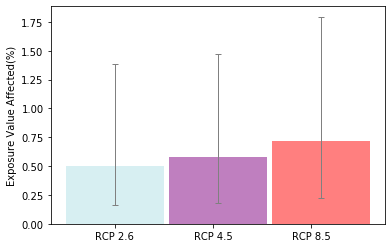

In [337]:
fig, ax = plt.subplots()
b_width = 0.21
colors =['powderblue','purple','red']

for j_,s_ in enumerate(ge_construction_2050_percentage):
    
    err = np.array([[ge_construction_2050_percentage[s_]['median']-ge_construction_2050_percentage[s_]['min']],[ge_construction_2050_percentage[s_]['max']-ge_construction_2050_percentage[s_]['median']]])

    ax.bar(j_*b_width,ge_construction_2050_percentage[s_]['median'],width = 0.2, yerr=err, error_kw=dict(barsabove=True, elinewidth=1, capsize=3,ecolor='gray'),label=s_,color = colors[j_],alpha=0.5)

    
        #ax.legend(h[:lc], l[:lc], loc=[1.01, 0.5])
        #ax.add_artist(l2)
#ax.set_title('Construction Sector Geneva 2050')
ax.set_ylabel('Exposure Value Affected(%)')
plt.xticks([0,0.2,0.4],['RCP 2.6','RCP 4.5','RCP 8.5'])

plt.savefig(''.join([fig_dir,'geneva_construction_sector_percentage.pdf']),bbox_inches='tight')




In [220]:
EXPOSURES_GE_construction['outside high expenditure'].value=EXPOSURES_GE_construction['outside high expenditure'].value*8*52*5

/Users/zeliestalhanske/anaconda3/climada_python-1.3.1/climada/util/plot.py:318: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


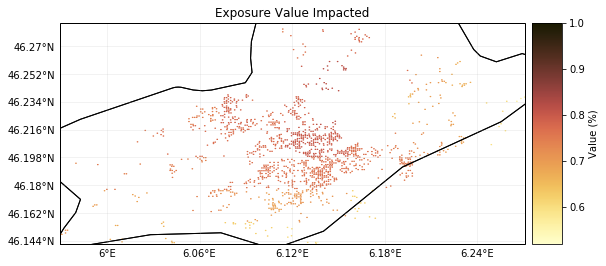

In [226]:
ge_construction_2050_percentage_impact['RCP85'].plot_hexbin_impact_exposure(event_id=[0],percentage=True,exposures=EXPOSURES_GE_construction['outside high expenditure'],pop_name = False,cmap=cm,vmax=1)
plt.savefig(''.join([fig_dir,'geneva_construction_sector_percentage_map.pdf']),bbox_inches='tight')


In [ ]:
#plot map + percentage of value impact in the construction sector in Geneva

## Adaptation Measures

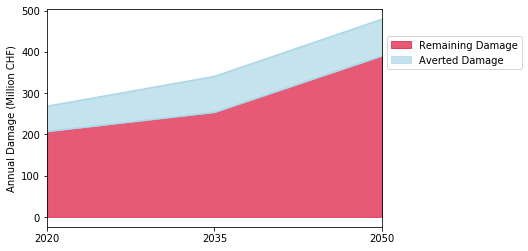

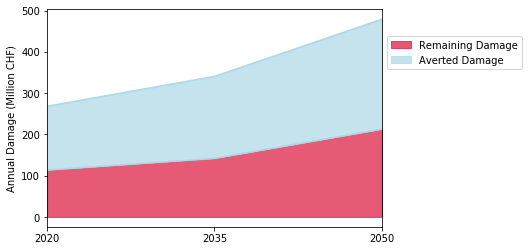

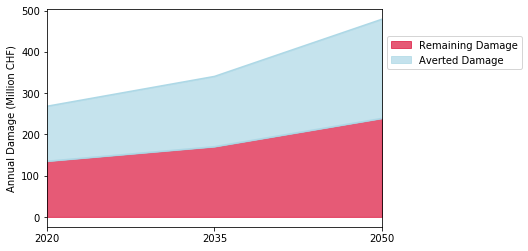

In [299]:
pickle_in = open('../../output/impact_ch/damage_cost_all_branches_1000mc_all_uncertainties_CH.pickle','rb')
no_adaptation = pickle.load(pickle_in)

pickle_in = open('../../output/impact_adaptation/damage_cost_all_branches_1000mc_all_uncertainties_adaptation_measures1_CH.pickle','rb')
damage_shadow = pickle.load(pickle_in)

pickle_in = open('../../output/impact_ch/damage_cost_all_branches_1000mc_all_uncertainties_CH.pickle','rb')
damage_efficient_buildings = pickle.load(pickle_in)


pickle_in = open('../../output/impact_adaptation/damage_cost_all_branches_1000mc_all_uncertainties_adaptation_measures3_6h10h16h20h_CH.pickle','rb')
damage_adapted_hours = pickle.load(pickle_in)

#pickle_in = open('../../output/impact_adaptation/damage_cost_all_branches_4mc_all_uncertainties_adaptation_measures1_2_3_CH.pickle','rb')
#all_measures = pickle.load(pickle_in)


s = 'RCP85'
#adaptation_dict = {'Efficient Buildings':damage_efficient_buildings, 'Adapted Hours':damage_adapted_hours}#,'Sun Protection':damage_shadow}
adaptation_dict = {'Sun Protection':damage_shadow,'Efficient Buildings':damage_efficient_buildings,'Adapted Hours':damage_adapted_hours}
adaptation_dict_years = {}


for s_ in no_adaptation:
    for y_ in no_adaptation[s_]:
        no_adaptation[s_][y_]['total'] = no_adaptation[s_][y_][list(no_adaptation[s_][y_].columns)].sum(axis=1)
        
        

for a_ in adaptation_dict:
    for s_ in adaptation_dict[a_]:
        for y_ in adaptation_dict[a_][s_]:
            if a_ == 'Efficient Buildings':
                adaptation_dict[a_][s_][y_]['total'] = adaptation_dict[a_][s_][y_][list(adaptation_dict[a_][s_][y_].columns)]['outside high expenditure']+adaptation_dict[a_][s_][y_][list(adaptation_dict[a_][s_][y_].columns)]['outside moderate expenditure']
            
            else:
                adaptation_dict[a_][s_][y_]['total'] = adaptation_dict[a_][s_][y_][list(adaptation_dict[a_][s_][y_].columns)].sum(axis=1)
            
            
    adaptation_dict_years[a_] = {}
    damage_normal_years = {}
    for s_ in adaptation_dict[a_]:
        adaptation_dict_years[a_][s_] = pd.DataFrame()
        damage_normal_years[s_] = pd.DataFrame()
        for y_ in adaptation_dict[a_][s_]:
            adaptation_dict_years[a_][s_]=adaptation_dict_years[a_][s_].append(pd.DataFrame(adaptation_dict[a_][s_][y_].median().to_dict(),index=[y_]))
            damage_normal_years[s_]=damage_normal_years[s_].append(pd.DataFrame(no_adaptation[s_][y_].median().to_dict(),index=[y_]))

    fig,ax=plt.subplots()
    
    ax.fill_between((adaptation_dict_years[a_][s]/1000000).index,(adaptation_dict_years[a_][s]['total']/1000000),label = 'Remaining Damage',color='crimson',alpha=0.7)
    ax.fill_between(damage_normal_years[s].index,(adaptation_dict_years[a_][s]['total']/1000000),damage_normal_years[s]['total']/1000000,label = 'Averted Damage',color='lightblue',alpha=0.7)

    (adaptation_dict_years[a_][s]['total']/1000000).plot.line(ax=ax,color='lightblue',label='_nolabel_')
    (damage_normal_years[s]['total']/1000000).plot.line(ax=ax,color='lightblue',label='_nolabel_')

    ax.set_ylabel('Annual Damage (Million CHF)')
    labels = ['2020','2035','2050']
    ax.legend(bbox_to_anchor=(1, 0.9))

    plt.savefig(''.join([fig_dir,a_,'_no_adaptation','.pdf']),bbox_inches='tight')


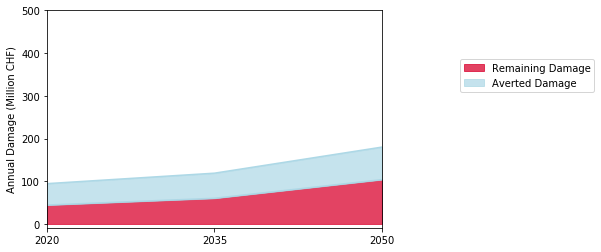

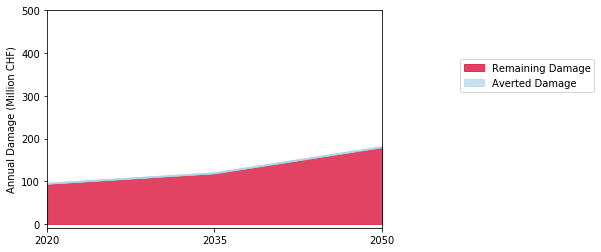

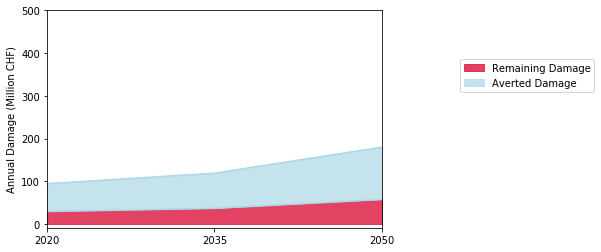

In [300]:
for a in adaptation_dict:
    fig,ax=plt.subplots()
    ax.fill_between(adaptation_dict_years[a][s].index,adaptation_dict_years[a][s]['outside high expenditure']/1000000,label = 'Remaining Damage',color='crimson',alpha=0.8)
    ax.fill_between(damage_normal_years[s].index,adaptation_dict_years[a][s]['outside high expenditure']/1000000,damage_normal_years[s]['outside high expenditure']/1000000,label = 'Averted Damage',color='lightblue',alpha=0.7)

    (adaptation_dict_years[a][s]['outside high expenditure']/1000000).plot.line(ax=ax,color='lightblue',label='_nolabel_')
    (damage_normal_years[s]['outside high expenditure']/1000000).plot.line(ax=ax,color='lightblue',label='_nolabel_')

    ax.legend(bbox_to_anchor=(1.65, 0.8))
    ax.set_ylabel('Annual Damage (Million CHF)')
    labels = ['2020','2035','2050']
    ax.set_ylim(top=500)

    plt.savefig(''.join([fig_dir,a,'_outside_high','.pdf']),bbox_inches='tight')



In [357]:
adaptation_dict_years['Sun Protection']['RCP85']['outside high expenditure']/damage_CH['RCP85']['2050']['outside high expenditure'].median()

2020    0.246147
2035    0.334324
2050    0.576874
Name: outside high expenditure, dtype: float64

In [338]:
RCP = {'RCP26':'RCP 2.6', 'RCP45':'RCP 4.5', 'RCP85':'RCP 8.5'}

ADAPTATIONS_2050 = {}
for s_ in damage_normal_years: 
    ADAPTATIONS_2050[RCP[s_]] = pd.DataFrame(columns=['Remaining Damage','Averted Damage'], index=list(adaptation_dict.keys()))
    for key in adaptation_dict:
        ADAPTATIONS_2050[RCP[s_]]['Remaining Damage'][key] = adaptation_dict[key][s_]['2050']['total'].median()/1000000 
        ADAPTATIONS_2050[RCP[s_]]['Averted Damage'][key] = (no_adaptation[s_]['2050']['total'].median() - adaptation_dict[key][s_]['2050']['total'].median())/1000000   
    


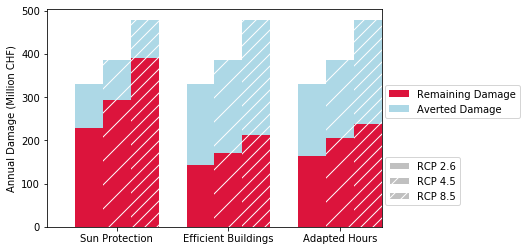

In [339]:

fig,ax=plt.subplots()

plot_clustered_stacked(ADAPTATIONS_2050,color= ['crimson','lightblue'],title= '')
plt.ylabel('Annual Damage (Million CHF)')
plt.savefig(''.join([fig_dir,'adaptations','.pdf']),bbox_inches='tight')


In [349]:
ADAPTATIONS_2050['RCP 8.5']['Averted Damage']/(ADAPTATIONS_2050['RCP 8.5']['Remaining Damage']+ADAPTATIONS_2050['RCP 8.5']['Averted Damage'])



Sun Protection         0.185468
Efficient Buildings    0.555682
Adapted Hours          0.501648
dtype: object